In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import roc_curve, auc,confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split,KFold,cross_val_predict
from sklearn.pipeline import Pipeline
import pylab
import scipy.stats as stats
SEED=42

In [3]:
df_train=pd.read_csv('../input/titanic/train.csv')
df_test=pd.read_csv('../input/titanic/test.csv')
df_all=pd.concat([df_train,df_test],axis=0)

submission_df=pd.DataFrame(columns=['PassengerId','Survived'])
submission_df['PassengerId']=df_test['PassengerId']

In [4]:
df_all.reset_index(drop=True,inplace=True)
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 1.Now we will start basic EDA

In [5]:
print('Number of Training Examples =',df_train.shape[0])
print('Number of Testing Examples =',df_test.shape[0])
print('Columns of training data: ',df_train.columns,'Number of columns:',len(df_train.columns))
print('Columns of testing data: ',df_test.columns,'Number of columns:',len(df_test.columns))
print('The extra column in training data is',set(df_train.columns)-set(df_test.columns))

Number of Training Examples = 891
Number of Testing Examples = 418
Columns of training data:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') Number of columns: 12
Columns of testing data:  Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') Number of columns: 11
The extra column in training data is {'Survived'}


The target variable here is **Survived**

In [6]:
print(df_all.Pclass.value_counts())
print(df_all.Embarked.value_counts())

3    709
1    323
2    277
Name: Pclass, dtype: int64
S    914
C    270
Q    123
Name: Embarked, dtype: int64


#### 1.1 **Overview of features**
* PassengerId has no effect on target var.
* Survived is the target variable(0 or 1):
    * 1=Survived
    * 0=Deceased
* Pclass( Passenger Class) is a categorical variable(ordinal) having 3 unique values (1,2,3):
    * 1=Upper Class
    * 2=Middle Class
    * 3=Lower Class
* Name, Sex and Age are self-explanatory
* SibSp is the total number of the passengers' siblings and spouse
* Parch is the total number of the passengers' parents and children
* Ticket is the ticket number of the passenger
* Fare is the passenger fare
* Cabin is the cabin number of the passenger
* Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
     * S is Southampton
     * C is Cherbourg
     * Q is Queenstown

In [7]:
def bar_plot(variable):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = df_all[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

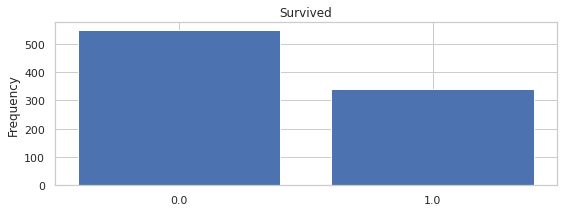

Survived: 
 0.0    549
1.0    342
Name: Survived, dtype: int64


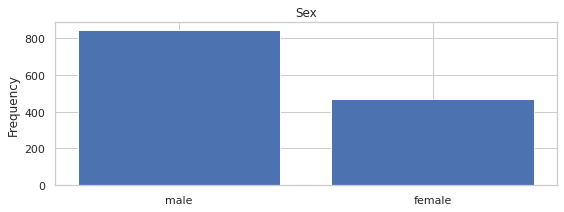

Sex: 
 male      843
female    466
Name: Sex, dtype: int64


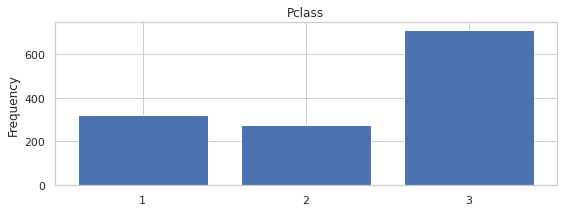

Pclass: 
 3    709
1    323
2    277
Name: Pclass, dtype: int64


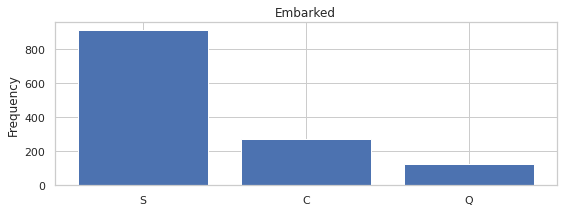

Embarked: 
 S    914
C    270
Q    123
Name: Embarked, dtype: int64


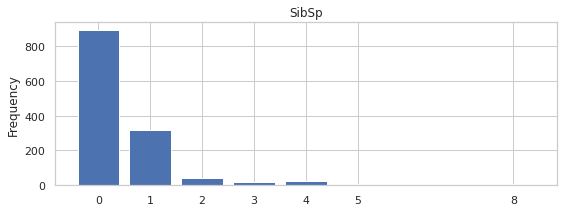

SibSp: 
 0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64


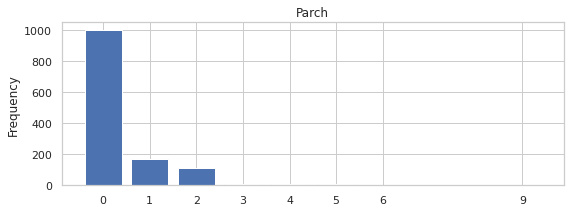

Parch: 
 0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: Parch, dtype: int64


In [8]:
category1 = ["Survived","Sex","Pclass","Embarked","SibSp", "Parch"]
for c in category1:
    bar_plot(c)

In [9]:


category2 = ["Cabin", "Name", "Ticket"]
for c in category2:
    print("{} \n".format(df_all[c].value_counts()))



C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64 

Connolly, Miss. Kate                                   2
Kelly, Mr. James                                       2
Braund, Mr. Owen Harris                                1
Johnson, Master. Harold Theodor                        1
Gustafsson, Mr. Alfred Ossian                          1
                                                      ..
Carter, Miss. Lucile Polk                              1
Silvey, Mr. William Baird                              1
Kallio, Mr. Nikolai Erland                             1
Louch, Mrs. Charles Alexander (Alice Adelaide Slow)    1
Peter, Master. Michael J                               1
Name: Name, Length: 1307, dtype: int64 

CA. 2343        11
CA 2144          8
1601             8
PC 

In [10]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(df_all[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()
    

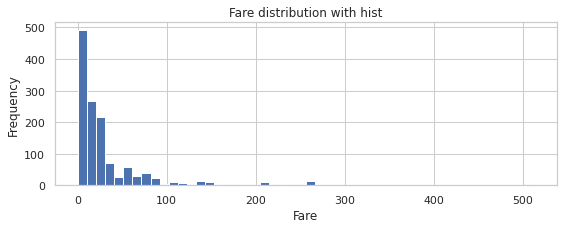

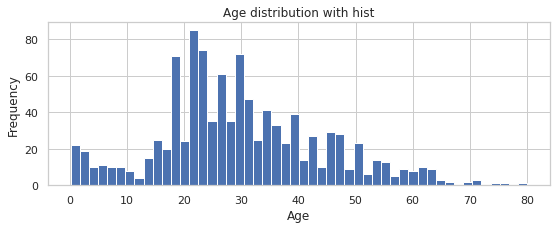

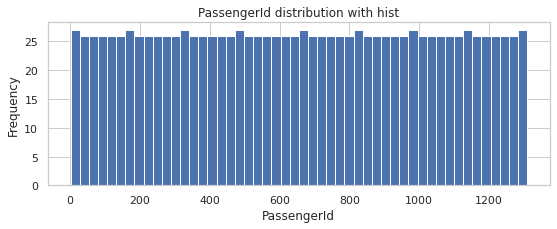

In [11]:
numericVar = ["Fare", "Age","PassengerId"]
for n in numericVar:
    plot_hist(n)

One can see the types of features

In [12]:

features_obj=[]
features_num=[]
for features in df_all.columns:
    if df_all[features].dtype=='object':
        features_obj.append(features)
    else:
        features_num.append(features)


**Here we have segregated the types of features**

In [13]:
print('String Features :', features_obj)
print('Numerical Features :',features_num )

String Features : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical Features : ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [14]:
df_all.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,0.028814,-0.077221,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.178740,0.160238,0.221539,1.000000


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Do some univariate analysis before filling out/Tableau

**1.2 Missing Values**
It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. 
The count of missing values in Age, Embarked and Fare are smaller compared to total sample, but roughly 80% of the Cabin is missing. Missing values in **Age, Embarked and Fare** can be filled with *descriptive statistical measures* but that wouldn't work for Cabin.

Studying correlations will help us a lot.


In [16]:
for feature in df_all.columns:
    print(feature,' percent missing value:',100*df_all[feature].isnull().sum()/df_all.shape[0])

PassengerId  percent missing value: 0.0
Survived  percent missing value: 31.932773109243698
Pclass  percent missing value: 0.0
Name  percent missing value: 0.0
Sex  percent missing value: 0.0
Age  percent missing value: 20.091673032849503
SibSp  percent missing value: 0.0
Parch  percent missing value: 0.0
Ticket  percent missing value: 0.0
Fare  percent missing value: 0.07639419404125286
Cabin  percent missing value: 77.46371275783041
Embarked  percent missing value: 0.15278838808250572


Text(0.5, 1.0, 'Pearson Correlation Heatmap')

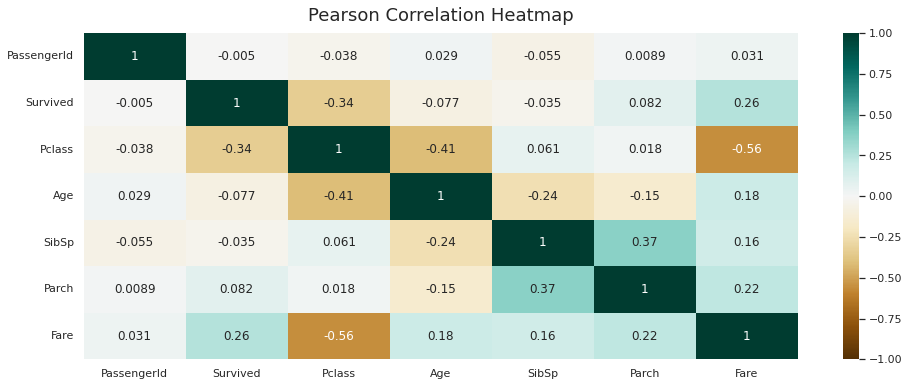

In [17]:
plt.figure(figsize=(16,6))
heatmap=sns.heatmap(df_all.corr(),vmin=-1,vmax=1,annot=True,cmap='BrBG')
heatmap.set_title('Pearson Correlation Heatmap',fontdict={'fontsize':18},pad=12)


**1.2.1 Age**
Missing values in Age are filled with

<AxesSubplot:>

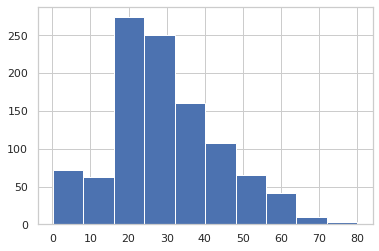

In [18]:
df_all.Age.hist(bins=10)

You can clearly see that the younger age bracket is mostly present

In [19]:
df_all[df_all.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [20]:
df_all.corr()[['Age']].sort_values(by='Age',ascending=False)

,Age
Age,1.000000
Fare,0.178740
PassengerId,0.028814
Survived,-0.077221
Parch,-0.150917
SibSp,-0.243699
Pclass,-0.408106


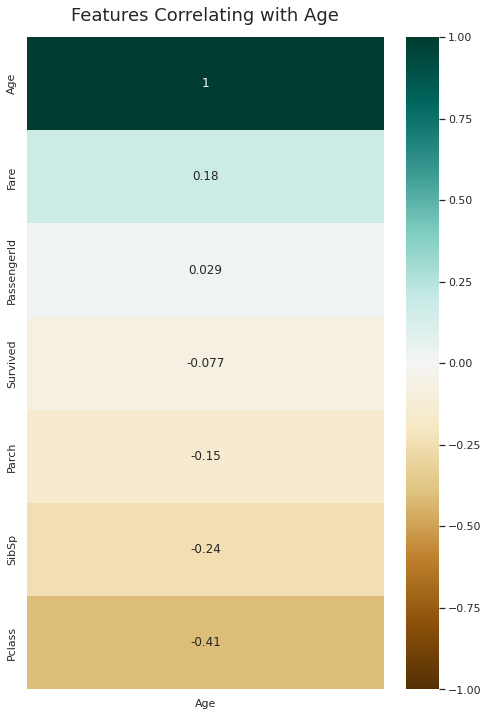

In [21]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_all.corr()[['Age']].sort_values(by='Age',ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Age', fontdict={'fontsize':18}, pad=16);

From here we can clearly assume that Pclass and Age are highly related.Therefore we will impute the missing value by median of the corresponding Pclass.
Also you must note that the median value will also be dependent on the Sex as the corr. only considers numerical features


In [22]:
df_all.groupby(['Pclass','Sex'])['Age'].median()

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64

In [23]:
df_all['Age']=df_all.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

Now we have imputed the Age, let's crosscheck. We have Fare,Cabin and Embarked left out.

In [24]:
df_all.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

**1.2.2 Embarked**

In [25]:
df_all[df_all.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
If you refer to this article, we can clearly infer that both of these survivors boarded from Southampton    

In [26]:
df_all.Embarked.fillna('S',inplace=True)

**1.2.3 Fare**

We will use the same technique as before and find out the correlations.

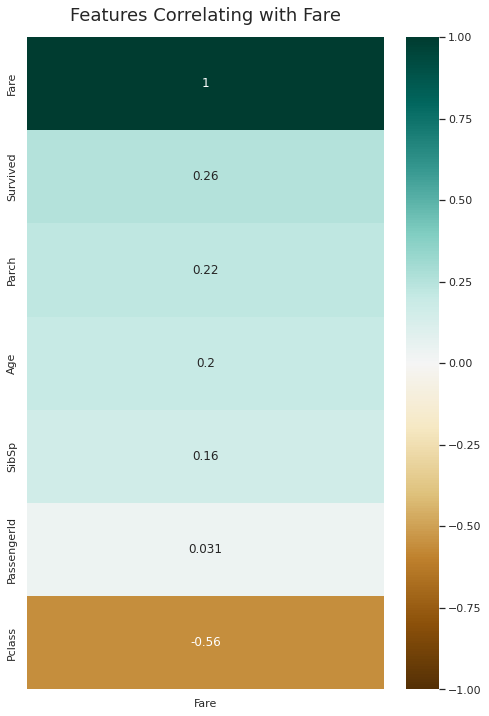

In [27]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_all.corr()[['Fare']].sort_values(by='Fare',ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Fare', fontdict={'fontsize':18}, pad=16);

We can infer that Fare is highly dependent on the Pclass & Age. Also one should not forget that Embarked and sex are equally important.

In [28]:
df_all[df_all.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [29]:
df_all.groupby(['Pclass','Sex','Age','Embarked'])['Fare'].mean()

Pclass  Sex     Age   Embarked
1       female  2.0   S           151.5500
                14.0  S           120.0000
                15.0  S           211.3375
                16.0  C            57.9792
                      S            62.9500
                                    ...   
3       male    60.5  S                NaN
                61.0  S             6.2375
                65.0  Q             7.7500
                70.5  Q             7.7500
                74.0  S             7.7750
Name: Fare, Length: 476, dtype: float64

We should safely fill this with 6.2375

In [30]:
df_all.Fare.fillna(6.2375,inplace=True)

In [31]:
df_all.Fare.isnull().sum()

0

**1.2.4 Cabin**
 It turns out to be the first letter of the Cabin values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes. 
 
 Here we will be doing some feature engg. to handle the missing values of cabin and ultimately drop Cabin Feature.

In [32]:
df_all['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

On the ship there were A-P Decks and we have only A,B,C,D,E,F,G,T survivers.

Deck  Pclass
A     1          22
B     1          65
C     1          94
D     1          40
      2           6
E     1          34
      2           4
      3           3
F     2          13
      3           8
G     3           5
M     3         693
      2         254
      1          67
T     1           1
Name: Pclass, dtype: int64


<AxesSubplot:xlabel='Deck,Pclass'>

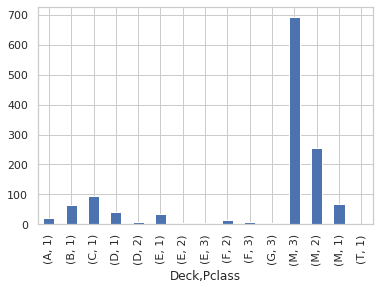

In [33]:
# Creating a Deck Column to extract the info from Cabin Column
#(M stands for Missing values)
df_all['Deck']=df_all['Cabin'].apply(lambda x:x[0] if pd.notnull(x) else 'M')
print(df_all.groupby('Deck')['Pclass'].value_counts())
df_all.groupby('Deck')['Pclass'].value_counts().plot(kind='bar')



   * 100% of A, B and C decks are 1st class passengers
   * Deck D has 87% 1st class and 13% 2nd class passengers
   * Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers
   * Deck F has 62% 2nd class and 38% 3rd class passengers
   * 100% of G deck are 3rd class passengers
   * There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck
   * Passengers labeled as M are the missing values in Cabin feature. I don't think it is possible to find those passengers' real Deck so I decided to use M like a deck.
   
   **In Feature Engineering I will try Ordinal Encoding on this feature.*



In [34]:

#now we can safely, remove the cabin feature.
df_all.drop('Cabin',axis=1,inplace=True)
df_all.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Deck             0
dtype: int64

### 2. **FEATURE engg.**

## **2.1 Feature Interaction & Extraction**

*2.1.1 Name-Title*

In [35]:
df_all['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [36]:
name=df_all.Name.to_list()
type(name[0])
df_all['Title']=[s.split('.')[0].split(',')[-1].strip() for s in name]

In [37]:
len(df_all['Title'])

1309

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Mr'),
  Text(1, 0, 'Miss'),
  Text(2, 0, 'Mrs'),
  Text(3, 0, 'Master'),
  Text(4, 0, 'Rev'),
  Text(5, 0, 'Dr'),
  Text(6, 0, 'Col'),
  Text(7, 0, 'Mlle'),
  Text(8, 0, 'Major'),
  Text(9, 0, 'Ms'),
  Text(10, 0, 'Lady'),
  Text(11, 0, 'Sir'),
  Text(12, 0, 'Mme'),
  Text(13, 0, 'Don'),
  Text(14, 0, 'Capt'),
  Text(15, 0, 'the Countess'),
  Text(16, 0, 'Jonkheer'),
  Text(17, 0, 'Dona')])

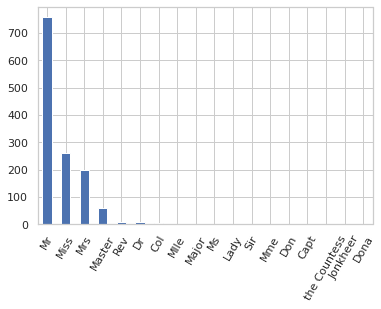

In [38]:
df_all.Title.value_counts().plot(kind='bar')
plt.xticks(rotation=60)


AxesSubplot(0.125,0.125;0.775x0.755)


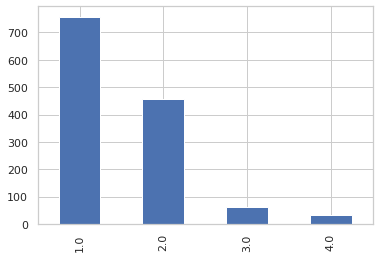

In [39]:
# Encoding this feature will be of great help 
print(df_all['Title'].map({'Mr':1,'Miss':2,'Mrs':2,'Master':3}).fillna(4).value_counts().plot(kind='bar'))
df_all['Title']=df_all['Title'].map({'Mr':1,'Miss':2,'Mrs':2,'Master':3}).fillna(4)

In [40]:
#df_all.drop('Name',axis=1,inplace=True)
df_all.info()
#df_all['PassengerId']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
 11  Deck         1309 non-null   object 
 12  Title        1309 non-null   float64
dtypes: float64(4), int64(4), object(5)
memory usage: 133.1+ KB


*****2.2.2 Parch & SibSp = FamilySize*****

In [41]:
df_all['Fsize']=df_all['SibSp']+df_all['Parch']
df_all['Fsize'].value_counts()
#df_all['Fsize'].plot(kind='bar')

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: Fsize, dtype: int64

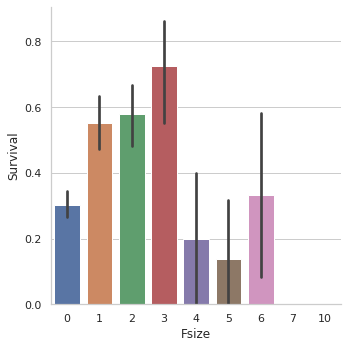

In [42]:
g=sns.catplot(x='Fsize',y='Survived',data=df_all,kind='bar')
g.set_ylabels('Survival')

In [43]:
# Encoding singles,small,medium and large families as {1,2,3,4}
df_all['family_size']=df_all.Fsize.map({0:1,1:2,2:2,3:2,4:3,5:3,6:3,7:4,10:4})

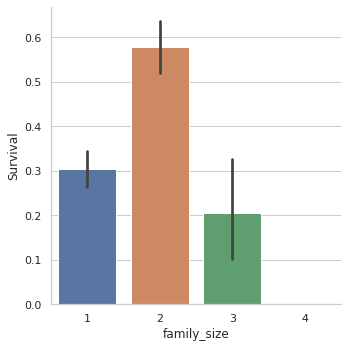

In [44]:
g=sns.catplot(x='family_size',y='Survived',data=df_all,kind='bar')
g.set_ylabels('Survival')

In [45]:
#df_all.drop(['SibSp','Parch'],axis=1,inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
 11  Deck         1309 non-null   object 
 12  Title        1309 non-null   float64
 13  Fsize        1309 non-null   int64  
 14  family_size  1309 non-null   int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 153.5+ KB


## **2.2 Encoding**

In [46]:
df_all['Sex']=df_all['Sex'].astype('category')
df_all=pd.get_dummies(df_all,columns=['Sex'])
#df_all.drop(['Sex_male'],axis=1,inplace=True)
df_all.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title,Fsize,family_size,Sex_female,Sex_male
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,M,1.0,1,2,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,C,2.0,1,2,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,M,2.0,0,1,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,C,2.0,1,2,1,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,M,1.0,0,1,0,1


In [47]:
df_all['Embarked']=df_all['Embarked'].astype('category')
df_all=pd.get_dummies(df_all,columns=['Embarked'])
df_all.head()
#OR
#df_temp=pd.get_dummies(df_all['Embarked'],drop_first=True)
#pd.concat with axis=1

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Deck,Title,Fsize,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,M,1.0,1,2,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,2.0,1,2,1,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,M,2.0,0,1,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C,2.0,1,2,1,0,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,M,1.0,0,1,0,1,0,0,1


In [48]:
df_all['Deck']=df_all['Deck'].astype('category')
df_all=pd.get_dummies(df_all,columns=['Deck'])
df_all.head()
#df_all=pd.get_dummies(df_all['Deck'],drop_first=True)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Title,Fsize,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1.0,1,2,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,2.0,1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,2.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2.0,1,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [49]:
df_all.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Title,Fsize,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1.0,1,2,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,2.0,1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,2.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2.0,1,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [50]:
#df_all.drop(['Name','SibSp','Parch','Embarked_C','Deck_A','Sex_male'],axis=1,inplace=True)

In [51]:
df_all["Pclass"] = df_all["Pclass"].astype("category")
df_all = pd.get_dummies(df_all, columns= ["Pclass"])
df_all.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Title,Fsize,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Pclass_1,Pclass_2,Pclass_3
0,1,0.0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1.0,1,2,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,2.0,1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,1.0,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,2.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2.0,1,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,5,0.0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1.0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [52]:
df_all["Title"] = df_all["Title"].astype("category")
df_all = pd.get_dummies(df_all, columns= ["Title"])
df_all.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Fsize,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Pclass_1,Pclass_2,Pclass_3,Title_1.0,Title_2.0,Title_3.0,Title_4.0
0,1,0.0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,2,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,3,1.0,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,5,0.0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0


In [53]:
#df_all.drop(['Fsize'],inplace=True,axis=1)
#As ticket helps to locate cabin,embarkment,Fare which is already given lets drop it too.
df_all_new=df_all.drop(['Pclass_1','Title_1.0','Ticket'],axis=1)

df_all_new.info()
df_all_new.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Name         1309 non-null   object 
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1309 non-null   float64
 7   Fsize        1309 non-null   int64  
 8   family_size  1309 non-null   int64  
 9   Sex_female   1309 non-null   uint8  
 10  Sex_male     1309 non-null   uint8  
 11  Embarked_C   1309 non-null   uint8  
 12  Embarked_Q   1309 non-null   uint8  
 13  Embarked_S   1309 non-null   uint8  
 14  Deck_A       1309 non-null   uint8  
 15  Deck_B       1309 non-null   uint8  
 16  Deck_C       1309 non-null   uint8  
 17  Deck_D       1309 non-null   uint8  
 18  Deck_E       1309 non-null   uint8  
 19  Deck_F

(1309, 28)

## **2.3 PreProcessing**
https://www.kaggle.com/code/prashant111/a-reference-guide-to-feature-engineering-methods/notebook

We will be scaling and normalizing Age and Fare

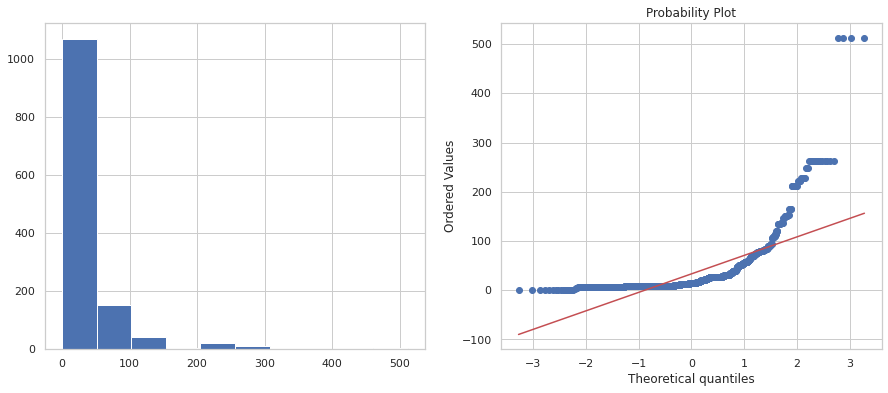

In [54]:
# plot the histograms to have a quick look at the distributions
# we can plot Q-Q plots to visualise if the variable is normally distributed

def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    
diagnostic_plots(df_all_new, 'Fare')

In [55]:
df_all_new.isnull().sum()

PassengerId      0
Survived       418
Name             0
Age              0
SibSp            0
Parch            0
Fare             0
Fsize            0
family_size      0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Deck_A           0
Deck_B           0
Deck_C           0
Deck_D           0
Deck_E           0
Deck_F           0
Deck_G           0
Deck_M           0
Deck_T           0
Pclass_2         0
Pclass_3         0
Title_2.0        0
Title_3.0        0
Title_4.0        0
dtype: int64

In [56]:
#df_all['Fare_log']=np.log(df_all.Fare)
#diagnostic_plots(df_all,'Fare_log')

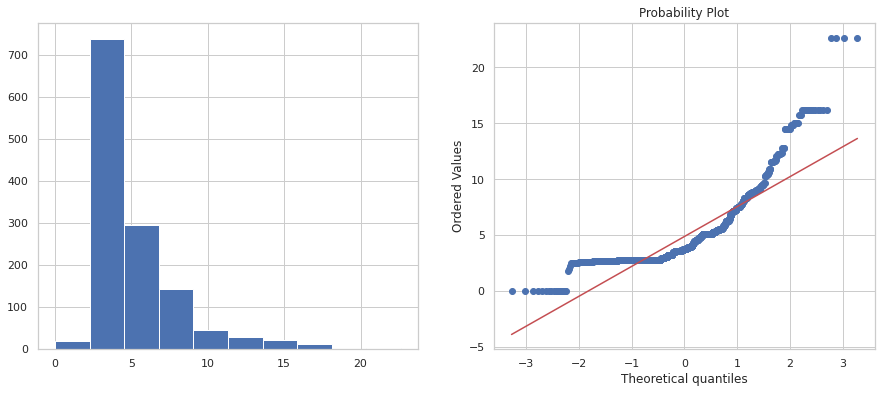

In [57]:
df_all_new['fare_sqr'] =df_all_new.Fare**(1/2)

diagnostic_plots(df_all_new, 'fare_sqr')

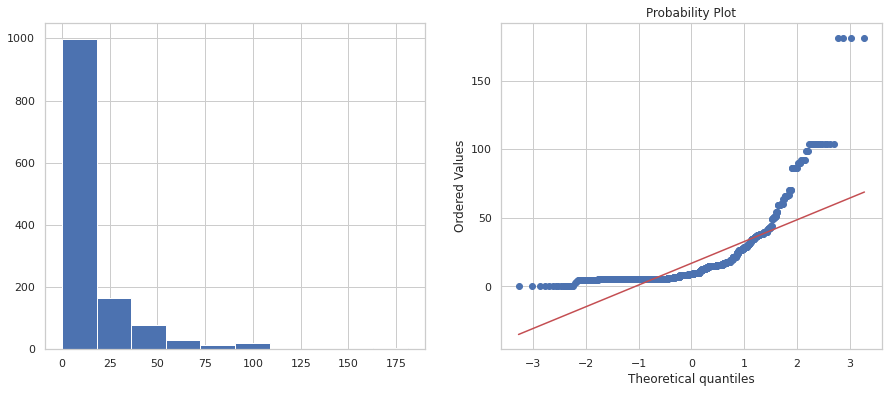

In [58]:
df_all_new['Fare_exp']=df_all_new.Fare**(1/1.2)
diagnostic_plots(df_all_new,'Fare_exp')

In [59]:
#df_all_new['Fare_boxcox'], param = stats.boxcox(df_all_new.Fare) 

#print('Optimal λ: ', param)

#diagnostic_plots(data, 'Fare_boxcox')

Optimal λ:  0.751393574356586


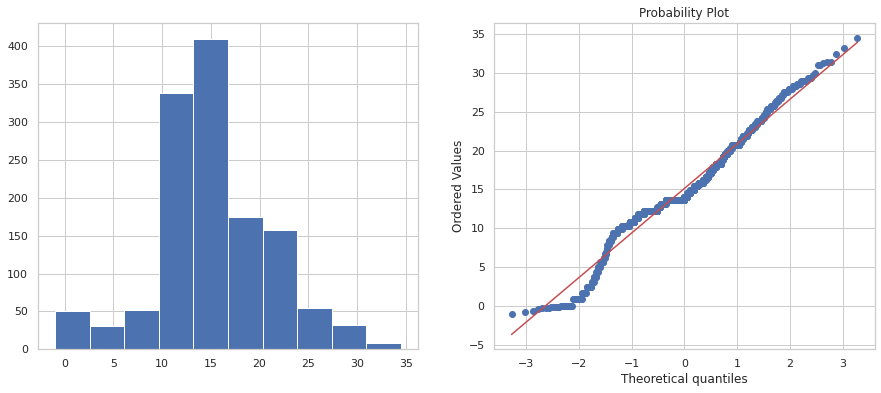

In [60]:
df_all_new['Age_boxcox'], param = stats.boxcox(df_all_new.Age) 

print('Optimal λ: ', param)

diagnostic_plots(df_all_new, 'Age_boxcox')

**Conclusion: We will be using Age_boxcox and fare_sqr**

In [61]:
df_all_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Name         1309 non-null   object 
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1309 non-null   float64
 7   Fsize        1309 non-null   int64  
 8   family_size  1309 non-null   int64  
 9   Sex_female   1309 non-null   uint8  
 10  Sex_male     1309 non-null   uint8  
 11  Embarked_C   1309 non-null   uint8  
 12  Embarked_Q   1309 non-null   uint8  
 13  Embarked_S   1309 non-null   uint8  
 14  Deck_A       1309 non-null   uint8  
 15  Deck_B       1309 non-null   uint8  
 16  Deck_C       1309 non-null   uint8  
 17  Deck_D       1309 non-null   uint8  
 18  Deck_E       1309 non-null   uint8  
 19  Deck_F

In [62]:
df_all_new.drop(['Fare_exp','Fare','Age'],axis=1,inplace=True)

In [63]:
df_all_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Name         1309 non-null   object 
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Fsize        1309 non-null   int64  
 6   family_size  1309 non-null   int64  
 7   Sex_female   1309 non-null   uint8  
 8   Sex_male     1309 non-null   uint8  
 9   Embarked_C   1309 non-null   uint8  
 10  Embarked_Q   1309 non-null   uint8  
 11  Embarked_S   1309 non-null   uint8  
 12  Deck_A       1309 non-null   uint8  
 13  Deck_B       1309 non-null   uint8  
 14  Deck_C       1309 non-null   uint8  
 15  Deck_D       1309 non-null   uint8  
 16  Deck_E       1309 non-null   uint8  
 17  Deck_F       1309 non-null   uint8  
 18  Deck_G       1309 non-null   uint8  
 19  Deck_M

In [64]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890].drop(['PassengerId'],axis=1), all_data.loc[891:].drop(['Survived','PassengerId'], axis=1)

In [65]:
df_train,df_test=divide_df(df_all_new)

In [66]:

df_train.drop('Name',inplace=True,axis=1)
df_train.columns

Index(['Survived', 'SibSp', 'Parch', 'Fsize', 'family_size', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M',
       'Deck_T', 'Pclass_2', 'Pclass_3', 'Title_2.0', 'Title_3.0', 'Title_4.0',
       'fare_sqr', 'Age_boxcox'],
      dtype='object')

In [67]:

df_test.drop('Name',inplace=True,axis=1)
df_test.columns

Index(['SibSp', 'Parch', 'Fsize', 'family_size', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'Pclass_2',
       'Pclass_3', 'Title_2.0', 'Title_3.0', 'Title_4.0', 'fare_sqr',
       'Age_boxcox'],
      dtype='object')

In [68]:
df=df_train.drop('Survived',axis=1)
target=df_train.Survived
X_train,X_test,y_train,y_test=train_test_split(df,target,test_size=0.3,random_state=SEED)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 25), (268, 25), (623,), (268,))

## **2.3 Modelling**

--------------The Accuracy of the model----------------------------
The cross validated score for Random Forest Classifier is: 82.83


Text(0.5, 1.05, 'Confusion_matrix')

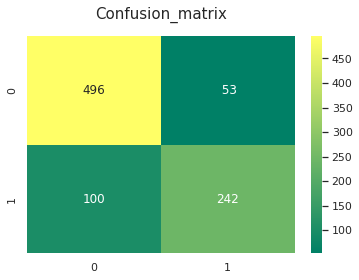

In [69]:
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
#model.fit(X_train,y_train)
#prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
#print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))

result_rm=cross_val_score(model,df,target,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
# for cross_val_pred no need of cross_val fitting
y_pred = cross_val_predict(model,df,target,cv=10)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

In [70]:
model.fit(df,target)
pred_test=model.predict(df_test)
df_test
#Comparison between models and tuning needs to be done

,SibSp,Parch,Fsize,family_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,Pclass_2,Pclass_3,Title_2.0,Title_3.0,Title_4.0,fare_sqr,Age_boxcox
891,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.798071,17.707954
892,1,0,1,2,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2.645751,22.687099
893,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,3.112475,28.244097
894,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.943213,14.505306
895,1,1,2,2,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,3.505353,12.246655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.837252,13.615507
1305,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,10.435516,19.545186
1306,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.692582,19.343759
1307,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2.837252,13.615507


In [71]:

submission_df['Survived']=pred_test
submission_df.to_csv('submissions.csv', header=True, index=False)